# Plot adjoint results and animate

## reference: Mazloff 2012

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from cmocean import cm
import xarray as xr
import xmitgcm 
import ecco_v4_py as ecco
import sys
sys.path.append('/efs_ecco/ECCO/EMU/emu_userinterface_dir/python')
import global_emu_var as emu
from matplotlib import animation

In [3]:
sys.path.append('/efs_ecco/ECCO/EMU/emu_userinterface_dir/')
import emu_plot_arg_py as ept

In [35]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [4]:
# Read in adjoint output using ept routine

globals_dict = ept.emu_plot(run_name="/efs_ecco/nrosenbe/emu_adj_12_12_1_drake_ssh_mask.bin_1/",
                            ctrl_num_list=[1, 2, 3, 4, 5, 6, 7, 8],
                            lag_beg=0, lag_end=1000000);

Found file: /efs_ecco/ECCO/EMU/emu_userinterface_dir/emu_env.singularity
EMU Input Files directory: /efs/owang/ECCO/EMU_test/emu_input_dir

Specified directory of EMU run to examine: /efs_ecco/nrosenbe/emu_adj_12_12_1_drake_ssh_mask.bin_1/

Reading /efs_ecco/nrosenbe/emu_adj_12_12_1_drake_ssh_mask.bin_1

Reading Adjoint Tool output ... 

Found file: adxx_empmr.0000000129.data

*********************************************
Read adjoint gradient for empmr
   adxx: adjoint gradient as a function of space and lag
from file /efs_ecco/nrosenbe/emu_adj_12_12_1_drake_ssh_mask.bin_1/output/adxx_empmr.0000000129.data
 
Zero lag at (week/record) = 54
Max  lag at (week/record) = 1
Specified start and end files #: 0 and 1000000

*********************************************
Outputting adxx_empmr

Found file: adxx_pload.0000000129.data

*********************************************
Read adjoint gradient for pload
   adxx: adjoint gradient as a function of space and lag
from file /efs_ecco/nrosenbe/e

In [ ]:

tauu = globals_dict['return_vars']['adxx_tauu']
tauv = globals_dict['return_vars']['adxx_tauv']

# Convert compact data to tile format

tauu = ecco.llc_compact_to_tiles(tauu)
tauv = ecco.llc_compact_to_tiles(tauv)

In [17]:
import ecco_access as ea
from os.path import join,expanduser
# identify user's home directory
user_home_dir = expanduser('~')
# download data and open xarray dataset
curr_shortname = 'ECCO_L4_GEOMETRY_LLC0090GRID_V4R4'

# load in grid data

grid = ea.ecco_podaac_to_xrdataset(curr_shortname,\
                                        StartDate='2017-01',EndDate='2017-12',\
                                        mode='download',\
                                        download_root_dir=join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC'))

created download directory /home/jovyan/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_GEOMETRY_LLC0090GRID_V4R4

GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading
DL Progress: 100%|#########################| 1/1 [00:00<00:00, 9962.72it/s]

total downloaded: 0.0 Mb
avg download speed: 0.0 Mb/s
Time spent = 0.0029401779174804688 seconds




In [31]:
# Regrid tile data to lat/lon using nearest neighbor

new_grid_delta_lat = 1
new_grid_delta_lon = 1

new_grid_min_lat = -90
new_grid_max_lat = 90

new_grid_min_lon = -180
new_grid_max_lon = 180

new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
tauu_rg =\
        ecco.resample_to_latlon(grid.XC, \
                                grid.YC, \
                                tauu,\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)

new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
tauv_rg = \
        ecco.resample_to_latlon(grid.XC, \
                                grid.YC, \
                                tauv,\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)

In [174]:
# Get bathymetry on same grid for plotting

_,_,_,_,bathy = ecco.resample_to_latlon(grid.XC, \
                                grid.YC, \
                                grid.Depth,\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)

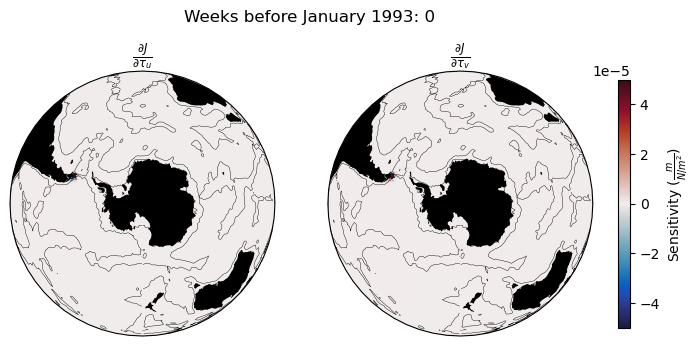

In [196]:
lons = new_grid_lon_centers
lats = new_grid_lat_centers

fig,axs = plt.subplots(1,2,figsize=(8,4),subplot_kw={'projection':ccrs.Orthographic(0,-90)})

# Plot results at zero lag

im1 = axs[0].pcolormesh(lons,lats,tauu_rg[0],transform=ccrs.PlateCarree(),
                        cmap=cm.balance,vmax = 0.00005,vmin=-0.00005)
im2 = axs[1].pcolormesh(lons,lats,tauv_rg[0],transform=ccrs.PlateCarree(),
                        cmap=cm.balance,vmax=0.00005,vmin=-0.00005)

axs[0].add_feature(cfeature.LAND,facecolor='k',zorder=10)
axs[1].add_feature(cfeature.LAND,facecolor='k',zorder=10)


axs[0].contour(lons,lats,bathy,transform=ccrs.PlateCarree(),
               levels=(0,3500),
               colors='k',
               linewidths=0.3,
               zorder=9)
axs[1].contour(lons,lats,bathy,transform=ccrs.PlateCarree(),
               levels=(0,3500),
               colors='k',
               linewidths=0.3,
               zorder=9)

axs[0].set_title(r'$\frac{\partial J}{\partial \tau_u}$')
axs[1].set_title(r'$\frac{\partial J}{\partial \tau_v}$')
#axs[0].set_extent([-180,180,-90,-60])

plt.colorbar(im2,ax = axs, fraction=0.02, pad=0.04,
            label=r'Sensitivity $(\frac{m}{N/m^2})$')

plt.suptitle(f'Weeks before January 1993: 0')

# Define plot update function to feed into FuncAnimation

def update(frame):
    im1.set_array(tauu_rg[frame].ravel())
    im2.set_array(tauv_rg[frame].ravel())
    plt.suptitle(f'Weeks before January 1993: {frame}')
    return [im1],[im2]

# Run animation
    
ani = animation.FuncAnimation(fig, update, frames = 12, interval=1000, blit=False)
mywriter = animation.FFMpegWriter(fps=4)
ani.save('animation.gif', writer='imagemagick', fps=4)

In [96]:
#!pip install haversine
from haversine import haversine_vector

In [130]:
# get distances between lats and lons on regular grid

dx = haversine_vector(np.dstack((lats[:,0],lons[:,0]))[0],
                      np.dstack((lats[:,0],lons[:,1]))[0],
                     unit = 'm')

dy = 111.19508023 * 1000

In [ ]:
# Compute curl of sensitivity to wind stress

dtauu_dy = (np.roll(tauu_rg,1,1)- tauu_rg)/dy

dtauv_dx = (np.roll(tauv_rg,1,2)-tauv_rg)/dx[np.newaxis,:,np.newaxis]

curltau = dtauv_dx - dtauu_dy

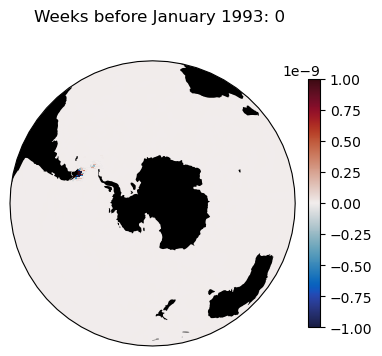

In [170]:
fig,axs = plt.subplots(1,1,figsize=(4,4),subplot_kw={'projection':ccrs.Orthographic(0,-90)})

im1 = axs.pcolormesh(lons,lats,curltau[5],transform=ccrs.PlateCarree(),
                        cmap=cm.balance,vmax = 1e-9,vmin=-1e-9)

plt.colorbar(im1,ax=axs,fraction=0.04, pad=0.04)

axs.add_feature(cfeature.LAND,facecolor='k',zorder=10)

def update(frame):
    im1.set_array(curltau[frame].ravel())
    plt.suptitle(f'Weeks before January 1993: {frame}')
    return [im1]

ani = animation.FuncAnimation(fig, update, frames = 12, interval=1000, blit=False)
#ani.save('myanimation.mp4',writer=mywriter)
ani.save('animation_curl.gif', writer='imagemagick', fps=4)